# Predictive Agent: Loan Approval Classification System
#### Project Description
The Predictive Agent is a machine learning module responsible for predicting whether a loan application will be approved or denied based on a combination of structured financial data and insights extracted from the applicant’s textual justification.


This agent enables financial institutions to make faster, data riven decisions by analyzing not only traditional credit related metrics but also the applicant's intent and context expressed in natural language.



#### Objectives
        Build a supervised classification model to predict the binary Loan Approval outcome (1 = Approved, 0 = Denied).
        
        Combine structured financial data with NLP-derived features like:
        
        Sentiment score from loan justification text
        
        Topic category representing the main theme of the justification
        
        Test multiple machine learning models (Logistic Regression, Random Foreset classifier, SVC).
        
        Apply cross-validation and hyperparameter tuning to select the best-performing model.
        
        Generate predictions on new applications and support live deployment in the pipeline.

#### Input Features
Structured financial attributes:

        Income
        
        Credit Score
        
        Loan Amount
        
        DTI Ratio
        
        Employment Status

NLP-derived attributes:

        Sentiment (e.g., positive/neutral/negative or continuous score)
        
        Topic (e.g., business expansion, education, medical emergency, etc.)

#### Output
        Prediction: Binary classification (Approved or Denied)
        
        Probability: Confidence score for the prediction (optional)
        
        Model Evaluation: Metrics across training, validation, test, and raw sets:
        
        Accuracy, Precision, Recall, F1-score, AUC
        
        Variance reporting to assess overfitting or underfitting

In [91]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
# SMOTE (Synthetic Minority Over-sampling Technique) to balance the class distribution
from imblearn.over_sampling import SMOTE , ADASYN

# FEature Importance
import shap
from sklearn.inspection import permutation_importance


# Preprocessing
from sklearn.preprocessing import RobustScaler, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.pipeline import Pipeline

# Error handling
import warnings
warnings.filterwarnings("ignore")

### Import data 


In [3]:
df = pd.read_csv('../data/cleaned/topic_label_check.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Income             24000 non-null  int64  
 1   Credit_Score       24000 non-null  int64  
 2   Loan_Amount        24000 non-null  int64  
 3   DTI_Ratio          24000 non-null  float64
 4   Employment_Status  24000 non-null  object 
 5   Sentiment          24000 non-null  object 
 6   topic              24000 non-null  int64  
 7   Approval           24000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 1.5+ MB


In [5]:
df.columns

Index(['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio',
       'Employment_Status', 'Sentiment', 'topic', 'Approval'],
      dtype='object')

In [9]:
df.duplicated().sum()

0

In [11]:
df.nunique()

Income               22456
Credit_Score           551
Loan_Amount          21249
DTI_Ratio             8033
Employment_Status        2
Sentiment                3
topic                    6
Approval                 2
dtype: int64

In [10]:
# Remember no missing values, No duplicates
# Data contains two categorical columns ( employement_status and Approval which is our target variable )

### EDA

#### Target variable , Approval 

In [14]:
counts

Approved    20067
Rejected     3933
Name: count, dtype: int64

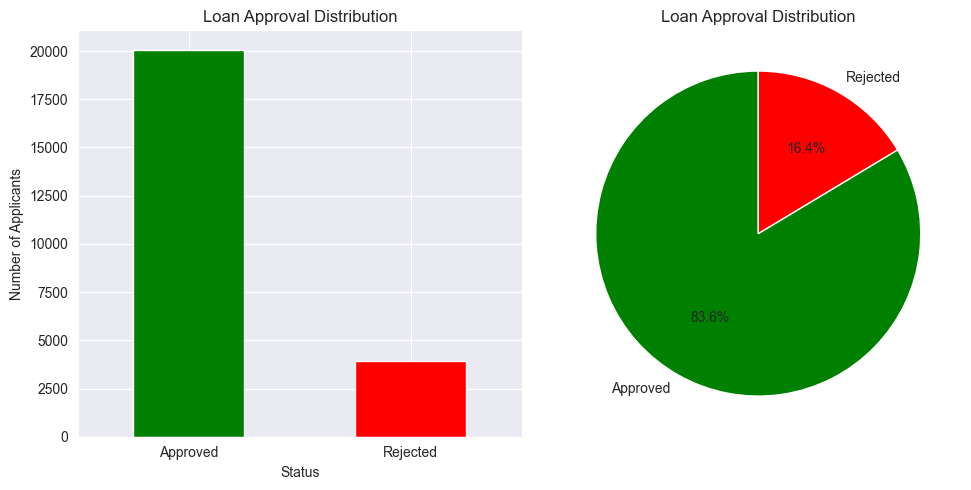

In [19]:
counts = df['Approval'].value_counts()
# Rename the indices
counts.index = ['Approved', 'Rejected']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

# Bar Plot on the first subplot (ax1)
counts.plot(kind='bar', color=['green', 'red'], title="Loan Approval Distribution", ax=ax1)
ax1.set_xlabel("Status")
ax1.set_ylabel("Number of Applicants")
ax1.tick_params(axis='x', rotation=0)


# Pie Chart on the second subplot (ax2)
ax2.pie(counts, labels=counts.index, autopct='%1.1f%%', colors=['green', 'red'], startangle=90)
ax2.set_title("Loan Approval Distribution")

# Display the subplots
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

#### Determinant analysis 

#### Income Analysis 


Do approved applicants generally have higher income?

Are there overlaps, or does income sharply separate approvals?

Are there outliers (like high income applicants who were denied?)

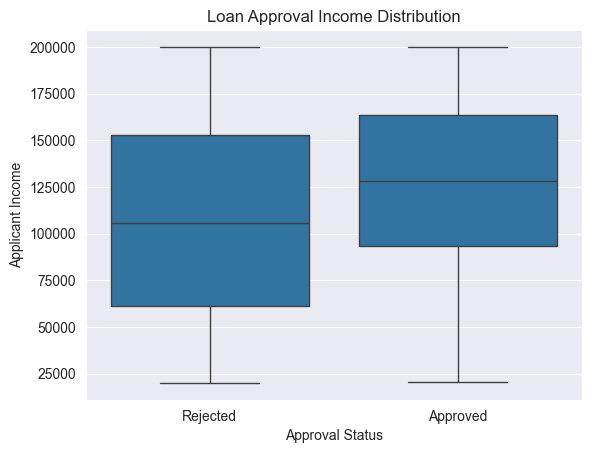

In [22]:
sns.boxplot(data=df, x='Approval', y='Income')
plt.title('Loan Approval Income Distribution')
plt.xlabel('Approval Status')
plt.ylabel('Applicant Income')
plt.show()

Insights :

        1. Generally the approved applicants have income above the average income of the rejected status applicants. Income doesnt sharply seperate the two groups, but we see a visible difference even with the overlaps. and lastly, there are high income applicants (salary > $125000) who were denied, no low income earners was approved. 

#### *Topic Trend Across Approvals*


Which topics are common in approved vs denied applications?

Do topics like "business expansion" get approved more often than "emergency medical"?

Are some topics consistently denied?

<Axes: xlabel='topic', ylabel='count'>

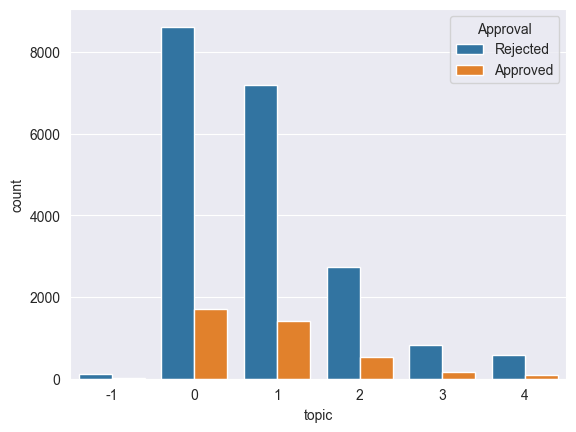

In [24]:
sns.countplot(data=df, x='topic', hue='Approval')

Insight:
          
           It is obvious here no one from the outlier group(-1) was approved a loan, and only a small group from each topic labels got approved.

#### Employemnt status and DTi trend

    Employment Status: Are unemployed applicants more likely to be denied?

    DTI Ratio: Higher ratios usually correlate with denials, is that whats happening here?
    
    Credit Score: Do approvals track strongly with higher scores?
    
    Loan Amount: Are bigger loans more likely to be rejected

<Axes: xlabel='Employment_Status', ylabel='count'>

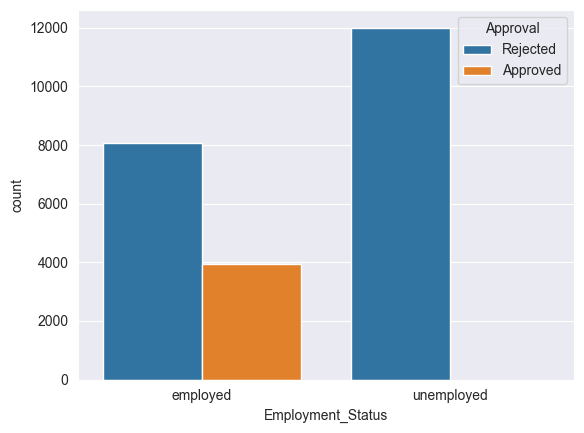

In [35]:

sns.countplot(data=df, x='Employment_Status', hue='Approval')

<Axes: xlabel='Approval', ylabel='DTI_Ratio'>

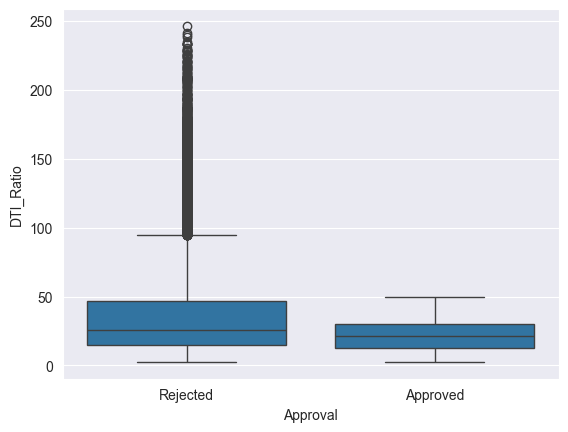

In [36]:
sns.boxplot(data=df, x='Approval', y='DTI_Ratio')

<Axes: xlabel='Approval', ylabel='Credit_Score'>

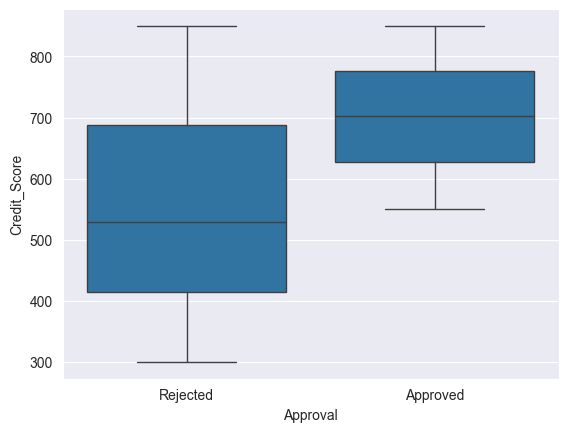

In [37]:
sns.boxplot(data=df, x='Approval', y='Credit_Score')

<Axes: xlabel='Approval', ylabel='Loan_Amount'>

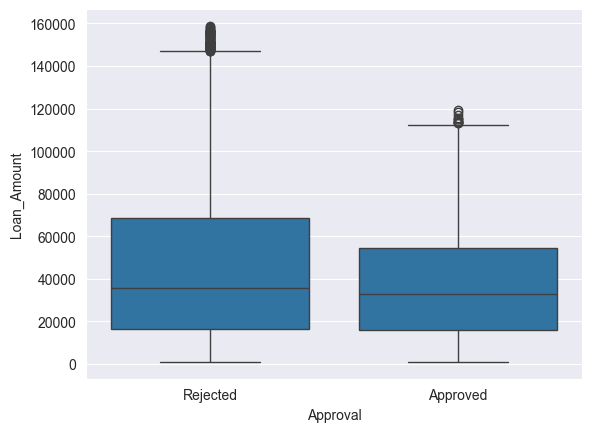

In [38]:
sns.boxplot(data=df, x='Approval', y='Loan_Amount')

Insight 
    
     Unemployed applicant do not get thier loan application approved, 
     Usually a higher loan amount gets rejected but we have few exempted cases, 
     yes, a higher credit scores correlates positively to getting your loan approved.
     All applicants with higher DTI ratio gets rejected, and we have approvals with clients with lesser dti ratios.
     

#### Feature Engineering


In [41]:
df2 = df.copy()

Encode Categorical variables

In [42]:
# map sentiment labels
df2['Sentiment_Encoded'] = df2['Sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})
# one hot encode Employemnt status
df2 = pd.get_dummies(df2, columns=['Employment_Status'], drop_first=True)
# label encode target variable
df2['Approval_Encoded'] = df2['Approval'].map({'Rejected': 0, 'Approved': 1})



In [43]:
df2.columns

Index(['Income', 'Credit_Score', 'Loan_Amount', 'DTI_Ratio', 'Sentiment',
       'topic', 'Approval', 'Credit_Bin', 'DTI_Bin', 'Sentiment_Encoded',
       'Employment_Status_unemployed', 'Approval_Encoded'],
      dtype='object')

In [44]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24000 entries, 0 to 23999
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Income                        24000 non-null  int64   
 1   Credit_Score                  24000 non-null  int64   
 2   Loan_Amount                   24000 non-null  int64   
 3   DTI_Ratio                     24000 non-null  float64 
 4   Sentiment                     24000 non-null  object  
 5   topic                         24000 non-null  int64   
 6   Approval                      24000 non-null  object  
 7   Credit_Bin                    23968 non-null  category
 8   DTI_Bin                       0 non-null      category
 9   Sentiment_Encoded             24000 non-null  int64   
 10  Employment_Status_unemployed  24000 non-null  bool    
 11  Approval_Encoded              24000 non-null  int64   
dtypes: bool(1), category(2), float64(1), int64(6),

#### Split data 


In [45]:
X = df2[['Income', 'Credit_Score', 'DTI_Ratio', 'Sentiment_Encoded','topic','Employment_Status_unemployed','Loan_Amount']]
y = df2['Approval_Encoded']

In [46]:
#  First split: Train + Temp  so 60% train, 20% val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: Train + Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)


In [54]:
print({X_train.shape})

print({X_val.shape})

print({X_test.shape})





{(14400, 7)}
{(4800, 7)}
{(4800, 7)}


#### Apply BAlacing technique as the destribution class of Approved loan request is the minority group making app. 16%


In [48]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [58]:
print(f"Before Smote : {y_train.value_counts()}")
print(f'after Smote: {pd.Series(y_resampled).value_counts()}')


Before Smote : Approval_Encoded
0    12040
1     2360
Name: count, dtype: int64
after Smote: Approval_Encoded
1    12040
0    12040
Name: count, dtype: int64


### Multivarant Analysis - ML


In [95]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(max_depth=4),
    'Random Forest': RandomForestClassifier(n_estimators=100)
}


In [70]:
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [84]:
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name):
    # Visual separator for each model
    print("\n" + "****" * 15)
    print(f"\n🧠 Evaluating: {model_name}")

    # Fit and predict
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Metrics for train and val
    metrics = {}
    for name, y_true, y_pred in [('train', y_train, y_train_pred), ('val', y_val, y_val_pred)]:
        metrics[name] = {
            'Accuracy': accuracy_score(y_true, y_pred),
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'F1': f1_score(y_true, y_pred),
            'AUC': roc_auc_score(y_true, y_pred)
        }

    # Print metrics with variance
    print(f"\n** {model_name} Performance**")
    for m in metrics['train']:
        train_val = metrics['train'][m]
        val_val = metrics['val'][m]
        print(f"{m:>9}: Train = {train_val:.3f} | Val = {val_val:.3f} | Variance = {train_val - val_val:.3f}")

    # Classification report
    print(f"\n** Classification Report (Validation - {model_name}**)")
    print(classification_report(y_val, y_val_pred, target_names=["Rejected", "Approved"]))

    # Confusion matrix
    plot_confusion(y_val, y_val_pred, f"{model_name} - Validation Confusion Matrix")

    # Feature importance (tree models)
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        sorted_idx = np.argsort(importance)[::-1]
        features = X_train.columns

        plt.figure(figsize=(6, 4))
        sns.barplot(x=importance[sorted_idx], y=features[sorted_idx])
        plt.title(f"{model_name} - Feature Importance (Variance Explained)")
        plt.xlabel("Importance Score")
        plt.ylabel("Features")
        plt.tight_layout()
        plt.show()



************************************************************

🧠 Evaluating: Logistic Regression

** Logistic Regression Performance**
 Accuracy: Train = 0.762 | Val = 0.707 | Variance = 0.055
Precision: Train = 0.731 | Val = 0.331 | Variance = 0.400
   Recall: Train = 0.830 | Val = 0.776 | Variance = 0.053
       F1: Train = 0.777 | Val = 0.464 | Variance = 0.313
      AUC: Train = 0.762 | Val = 0.735 | Variance = 0.027

** Classification Report (Validation - Logistic Regression**)
              precision    recall  f1-score   support

    Rejected       0.94      0.69      0.80      4014
    Approved       0.33      0.78      0.46       786

    accuracy                           0.71      4800
   macro avg       0.64      0.73      0.63      4800
weighted avg       0.84      0.71      0.74      4800



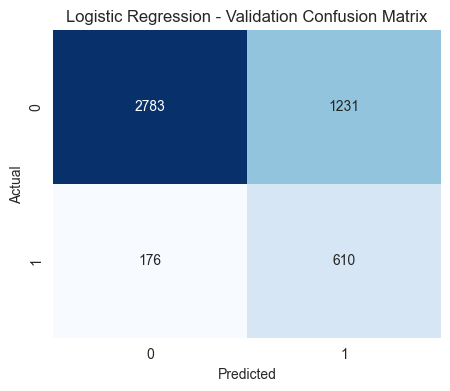


************************************************************

🧠 Evaluating: Decision Tree

** Decision Tree Performance**
 Accuracy: Train = 0.975 | Val = 0.961 | Variance = 0.014
Precision: Train = 0.957 | Val = 0.809 | Variance = 0.148
   Recall: Train = 0.994 | Val = 0.996 | Variance = -0.002
       F1: Train = 0.975 | Val = 0.893 | Variance = 0.082
      AUC: Train = 0.975 | Val = 0.975 | Variance = -0.000

** Classification Report (Validation - Decision Tree**)
              precision    recall  f1-score   support

    Rejected       1.00      0.95      0.98      4014
    Approved       0.81      1.00      0.89       786

    accuracy                           0.96      4800
   macro avg       0.90      0.98      0.93      4800
weighted avg       0.97      0.96      0.96      4800



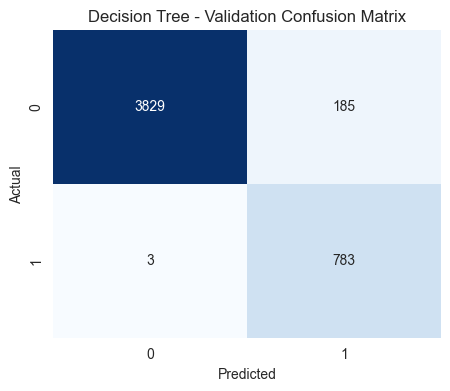

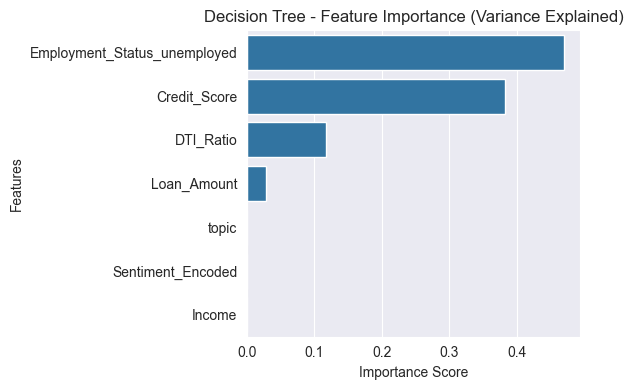


************************************************************

🧠 Evaluating: Random Forest

** Random Forest Performance**
 Accuracy: Train = 1.000 | Val = 0.991 | Variance = 0.009
Precision: Train = 1.000 | Val = 0.957 | Variance = 0.043
   Recall: Train = 1.000 | Val = 0.987 | Variance = 0.013
       F1: Train = 1.000 | Val = 0.972 | Variance = 0.028
      AUC: Train = 1.000 | Val = 0.989 | Variance = 0.011

** Classification Report (Validation - Random Forest**)
              precision    recall  f1-score   support

    Rejected       1.00      0.99      0.99      4014
    Approved       0.96      0.99      0.97       786

    accuracy                           0.99      4800
   macro avg       0.98      0.99      0.98      4800
weighted avg       0.99      0.99      0.99      4800



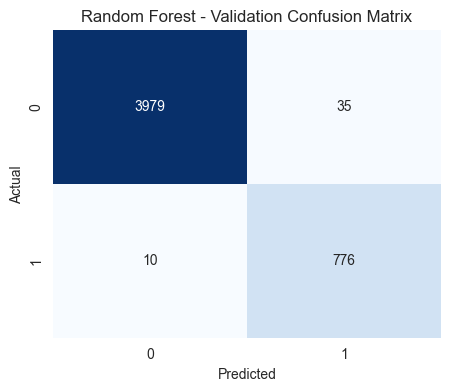

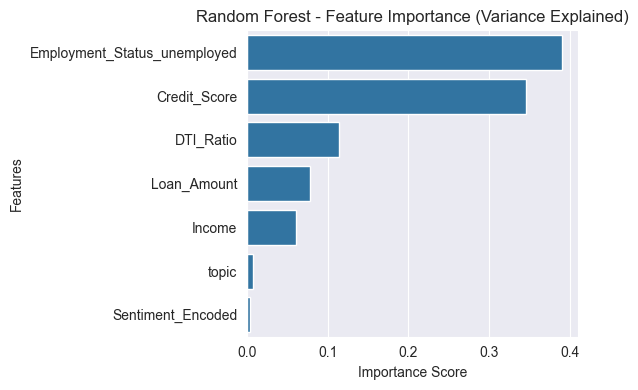

In [102]:
# Train and evaluate and loop through models
for name, model in models.items():
    evaluate_model(model, X_resampled, y_resampled, X_val, y_val, model_name=name)

Insight : 

       All of the models are overfitting , lets do parameter tuning 

#### Hyper parameter tuning

In [86]:
# Logistic Regression
logreg_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear'],
    'class_weight': [None, 'balanced']
}

logreg_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid=logreg_params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
logreg_grid.fit(X_resampled, y_resampled)
print("************************************************************")
print(" Best Logistic Regression Parameters:")
print(logreg_grid.best_params_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
************************************************************
🔍 Best Logistic Regression Parameters:
{'C': 10, 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}


In [87]:
# Decision Tree
dt_params = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5],
    'ccp_alpha': [0.0, 0.01, 0.05]
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=dt_params,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)
dt_grid.fit(X_resampled, y_resampled)
print("************************************************************")
print(" Best Decision Tree Parameters:")
print(dt_grid.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
************************************************************
🌳 Best Decision Tree Parameters:
{'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [92]:
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=20,  # Number of random combinations
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=1
)

rf_random.fit(X_resampled, y_resampled)
print("Best RF Randomized Parameters:", rf_random.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best RF Randomized Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced'}


In [103]:
# Initialize models
tuned_models = {
    'Logistic Regression': LogisticRegression(C=10, class_weight=None, penalty='l2', solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(ccp_alpha=0.0, max_depth=None, min_samples_leaf=1, min_samples_split=2),
    'Random Forest': RandomForestClassifier(n_estimators=100, min_samples_split=2, min_samples_leaf=1,
                                            max_features='sqrt', max_depth=None, class_weight='balanced')
}


************************************************************

🧠 Evaluating: Logistic Regression

** Logistic Regression Performance**
 Accuracy: Train = 0.765 | Val = 0.712 | Variance = 0.053
Precision: Train = 0.734 | Val = 0.336 | Variance = 0.398
   Recall: Train = 0.832 | Val = 0.777 | Variance = 0.054
       F1: Train = 0.780 | Val = 0.469 | Variance = 0.311
      AUC: Train = 0.765 | Val = 0.738 | Variance = 0.027

** Classification Report (Validation - Logistic Regression**)
              precision    recall  f1-score   support

    Rejected       0.94      0.70      0.80      4014
    Approved       0.34      0.78      0.47       786

    accuracy                           0.71      4800
   macro avg       0.64      0.74      0.64      4800
weighted avg       0.84      0.71      0.75      4800



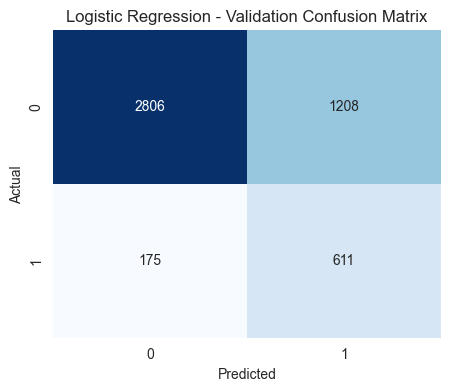


************************************************************

🧠 Evaluating: Decision Tree

** Decision Tree Performance**
 Accuracy: Train = 1.000 | Val = 0.994 | Variance = 0.006
Precision: Train = 1.000 | Val = 0.980 | Variance = 0.020
   Recall: Train = 1.000 | Val = 0.986 | Variance = 0.014
       F1: Train = 1.000 | Val = 0.983 | Variance = 0.017
      AUC: Train = 1.000 | Val = 0.991 | Variance = 0.009

** Classification Report (Validation - Decision Tree**)
              precision    recall  f1-score   support

    Rejected       1.00      1.00      1.00      4014
    Approved       0.98      0.99      0.98       786

    accuracy                           0.99      4800
   macro avg       0.99      0.99      0.99      4800
weighted avg       0.99      0.99      0.99      4800



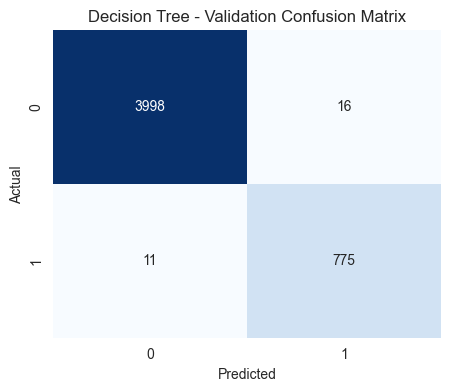

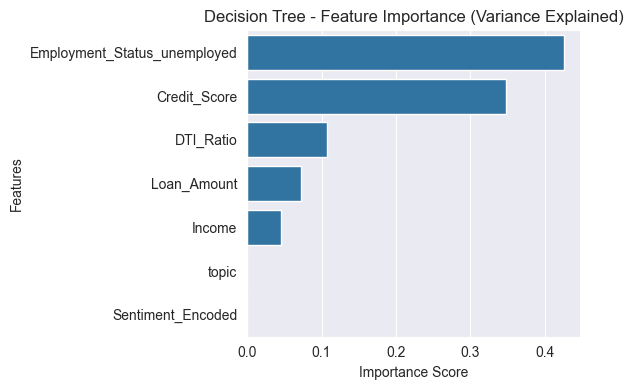


************************************************************

🧠 Evaluating: Random Forest

** Random Forest Performance**
 Accuracy: Train = 1.000 | Val = 0.990 | Variance = 0.010
Precision: Train = 1.000 | Val = 0.952 | Variance = 0.048
   Recall: Train = 1.000 | Val = 0.991 | Variance = 0.009
       F1: Train = 1.000 | Val = 0.971 | Variance = 0.029
      AUC: Train = 1.000 | Val = 0.991 | Variance = 0.009

** Classification Report (Validation - Random Forest**)
              precision    recall  f1-score   support

    Rejected       1.00      0.99      0.99      4014
    Approved       0.95      0.99      0.97       786

    accuracy                           0.99      4800
   macro avg       0.98      0.99      0.98      4800
weighted avg       0.99      0.99      0.99      4800



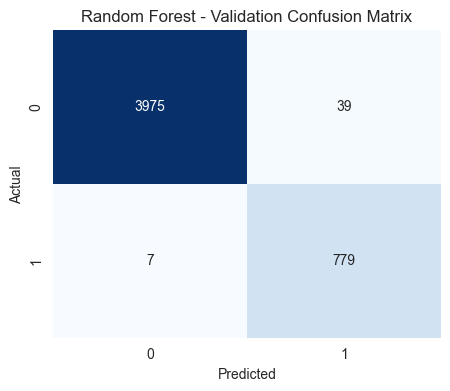

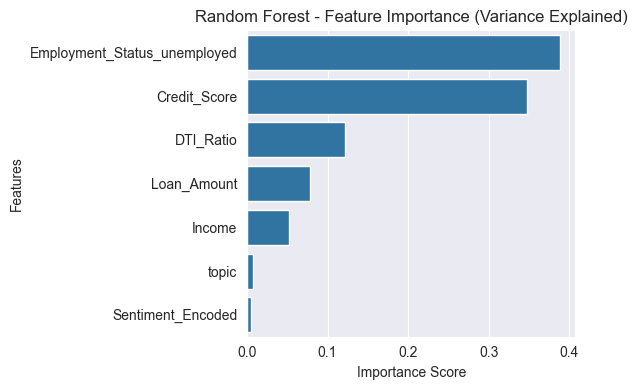

In [104]:
# Train and evaluate and loop through models
for name, model in tuned_models.items():
    evaluate_model(model, X_resampled, y_resampled, X_val, y_val, model_name=name)

Insight : 

    Initial model setup was better, variance became higher after parameter tuning and overfitting is present.

In [100]:
# Combine train + val
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

In [101]:
# Reapply SMOTE on the combined training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_full, y_train_full)


************************************************************

🧠 Evaluating: Logistic Regression

** Logistic Regression Performance**
 Accuracy: Train = 0.759 | Val = 0.713 | Variance = 0.047
Precision: Train = 0.729 | Val = 0.338 | Variance = 0.391
   Recall: Train = 0.825 | Val = 0.784 | Variance = 0.041
       F1: Train = 0.774 | Val = 0.472 | Variance = 0.302
      AUC: Train = 0.759 | Val = 0.741 | Variance = 0.018

** Classification Report (Validation - Logistic Regression**)
              precision    recall  f1-score   support

    Rejected       0.94      0.70      0.80      4013
    Approved       0.34      0.78      0.47       787

    accuracy                           0.71      4800
   macro avg       0.64      0.74      0.64      4800
weighted avg       0.84      0.71      0.75      4800



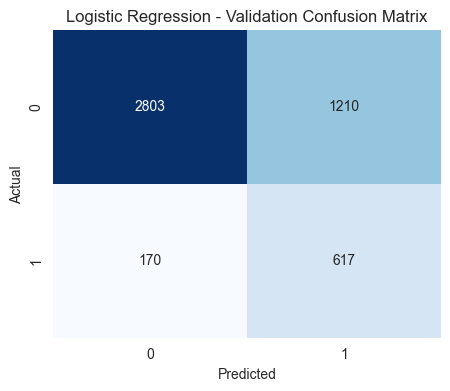


************************************************************

🧠 Evaluating: Decision Tree

** Decision Tree Performance**
 Accuracy: Train = 0.975 | Val = 0.959 | Variance = 0.016
Precision: Train = 0.957 | Val = 0.805 | Variance = 0.152
   Recall: Train = 0.995 | Val = 0.990 | Variance = 0.005
       F1: Train = 0.976 | Val = 0.888 | Variance = 0.088
      AUC: Train = 0.975 | Val = 0.971 | Variance = 0.004

** Classification Report (Validation - Decision Tree**)
              precision    recall  f1-score   support

    Rejected       1.00      0.95      0.97      4013
    Approved       0.80      0.99      0.89       787

    accuracy                           0.96      4800
   macro avg       0.90      0.97      0.93      4800
weighted avg       0.97      0.96      0.96      4800



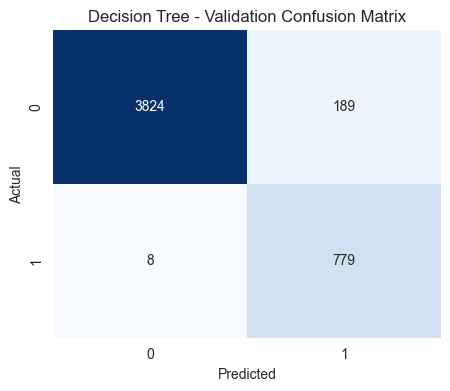

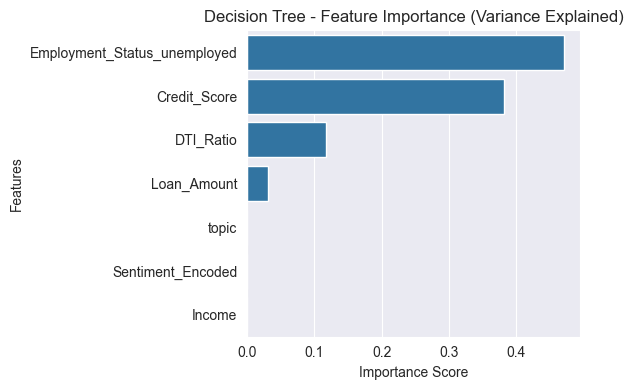


************************************************************

🧠 Evaluating: Random Forest

** Random Forest Performance**
 Accuracy: Train = 1.000 | Val = 0.994 | Variance = 0.006
Precision: Train = 1.000 | Val = 0.968 | Variance = 0.032
   Recall: Train = 1.000 | Val = 0.994 | Variance = 0.006
       F1: Train = 1.000 | Val = 0.981 | Variance = 0.019
      AUC: Train = 1.000 | Val = 0.994 | Variance = 0.006

** Classification Report (Validation - Random Forest**)
              precision    recall  f1-score   support

    Rejected       1.00      0.99      1.00      4013
    Approved       0.97      0.99      0.98       787

    accuracy                           0.99      4800
   macro avg       0.98      0.99      0.99      4800
weighted avg       0.99      0.99      0.99      4800



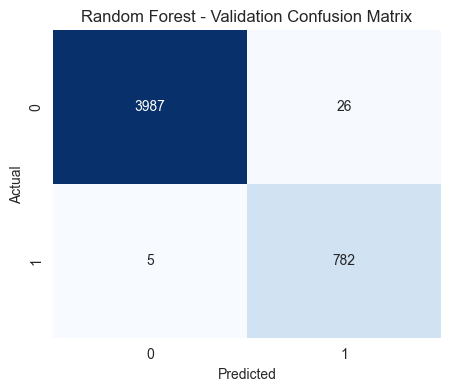

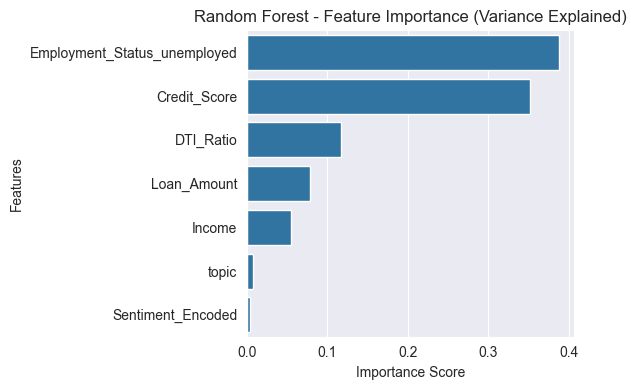

In [106]:
# Train and evaluate and loop through models
for name, model in models.items():
    evaluate_model(model, X_train_resampled, y_train_resampled, X_test, y_test, model_name=name)

In [ ]:
final_model = RandomForestClassifier()